In [1]:
import os
import cv2
import random
import shutil
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt

from tqdm import tqdm
from glob import glob

In [2]:
dir = "/home/pervinco/Datasets/BKAI_IGH_NeoPolyp/"

In [3]:
def read_txt():
    names = ["red", "green", "rng"]
    files = {}

    for name in names:
        with open(f"{dir}/{name}.txt", "r") as f:
            file_list = f.readlines()
        file_list = [x.strip() for x in file_list]

        files.update({name : file_list})
    
    return files


total = read_txt()
for name, files in total.items():
    print(name, len(files))

red 694
green 257
rng 49


In [4]:
def visualize(image, mask, t_image, t_mask):
    original = cv2.addWeighted(image, 0.7, mask, 0.3, 0)
    original = cv2.resize(original, (256, 256))

    transformed = cv2.addWeighted(t_image, 0.7, t_mask, 0.3, 0)

    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(original)

    plt.subplot(1, 2, 2)
    plt.imshow(transformed)

In [5]:
transform = A.Compose([A.OneOf([A.Resize(256, 256, p=0.5),
                       A.RandomCrop(height=256, width=256, p=0.0)], p=1),
                       
                       A.OneOf([A.Flip(p=0.3),
                                A.ShiftScaleRotate(shift_limit_x=(-0.06, 0.06),
                                                   shift_limit_y=(-0.06, 0.06), 
                                                   scale_limit=(-0.3, 0.1),
                                                   rotate_limit=(-90, 90),
                                                   interpolation=0,
                                                   border_mode=0,
                                                   value=(0, 0, 0),
                                                   mask_value=None, 
                                                   rotate_method='largest_box',
                                                   p=0.7)], p=1),
])

In [6]:
green_files = total["green"]
file = green_files[0]

image = cv2.imread(f"{dir}/train/{file}.jpeg")
mask = cv2.imread(f"{dir}/train_gt/{file}.jpeg")

# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

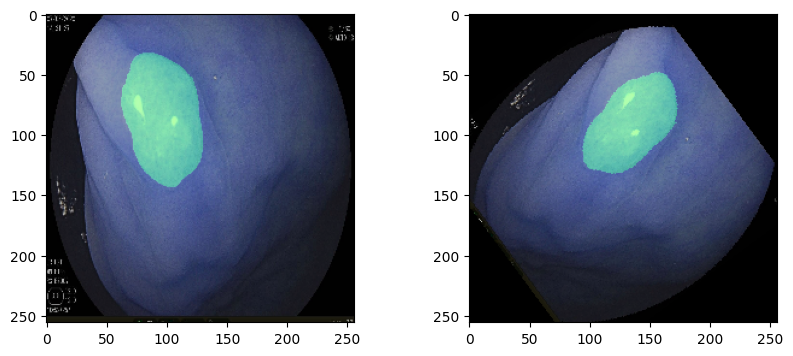

In [7]:
transformed = transform(image=image, mask=mask)
transformed_image = transformed['image']
transformed_mask = transformed['mask']

visualize(image, mask, transformed_image, transformed_mask)

In [8]:
def mosaic_augmentation(files, output_size=(256, 256)):
    h, w = output_size
    mosaic_img = np.zeros((h, w, 3), dtype=np.uint8)
    mosaic_mask = np.zeros((h, w, 3), dtype=np.uint8)
    
    # 중심점 지정
    cx, cy = random.randint(w//4, 3*w//4), random.randint(h//4, 3*h//4)
    
    indices = [0, 1, 2, 3]
    random.shuffle(indices)
    
    for i, index in enumerate(indices):
        image = cv2.imread(f"{dir}/train/{files[index]}.jpeg")
        mask = cv2.imread(f"{dir}/train_gt/{files[index]}.jpeg")

        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

        if i == 0:
            mosaic_img[:cy, :cx] = cv2.resize(image, (cx, cy))
            mosaic_mask[:cy, :cx] = cv2.resize(mask, (cx, cy))
        elif i == 1:
            mosaic_img[:cy, cx:] = cv2.resize(image, (w-cx, cy))
            mosaic_mask[:cy, cx:] = cv2.resize(mask, (w-cx, cy))
        elif i == 2:
            mosaic_img[cy:, :cx] = cv2.resize(image, (cx, h-cy))
            mosaic_mask[cy:, :cx] = cv2.resize(mask, (cx, h-cy))
        elif i == 3:
            mosaic_img[cy:, cx:] = cv2.resize(image, (w-cx, h-cy))
            mosaic_mask[cy:, cx:] = cv2.resize(mask, (w-cx, h-cy))
    
    return mosaic_img, mosaic_mask


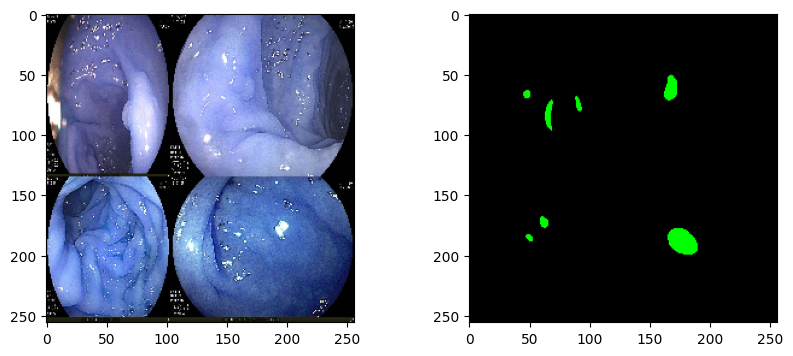

In [9]:
selected_files = random.sample(green_files, 4)
mosaic_img, mosaic_mask = mosaic_augmentation(selected_files)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(mosaic_img)

plt.subplot(1, 2, 2)
plt.imshow(mosaic_mask)

In [10]:
output_img_dir = f"{dir}/train_aug/train"
output_gt_dir = f"{dir}/train_aug/train_gt"

if not os.path.isdir(f"{dir}/train_aug"):
    os.makedirs(output_img_dir)
    os.makedirs(output_gt_dir)

In [11]:
for label, files in total.items():
    for file in files:
        img_path = f"{dir}/train/{file}.jpeg"
        mask_path = f"{dir}/train_gt/{file}.jpeg"

        shutil.copy(img_path, f"{output_img_dir}/{file}.jpeg")
        shutil.copy(mask_path, f"{output_gt_dir}/{file}.jpeg")

In [12]:
images = sorted(glob(f"{dir}/train_aug/train/*.jpeg"))
masks = sorted(glob(f"{dir}/train_aug/train_gt/*.jpeg"))

train_files, valid_files = [], []
ratio = [[555, 139], [206, 51], [39, 10]]
for idx, (name, files) in enumerate(total.items()):
    random.shuffle(files)
    train_files.extend(files[:ratio[idx][0]])
    valid_files.extend(files[ratio[idx][0]:])

print(len(train_files), len(valid_files))


800 200


In [13]:
tmp = train_files.copy()

for i in tqdm(range(len(tmp))):
    prob = random.random()
    for idx in range(5):
        if prob > 0.5:
            selected_files = random.sample(tmp, 4)
            t_image, t_mask = mosaic_augmentation(selected_files)

        else:
            file = tmp[random.randint(0, len(tmp) - 1)]
            image = cv2.imread(f"{output_img_dir}/{file}.jpeg")
            mask = cv2.imread(f"{output_gt_dir}/{file}.jpeg")

            transformed = transform(image=image, mask=mask)
            t_image = transformed['image']
            t_mask = transformed['mask']

        file_name = f"{i:>04}_{idx:>02}"
        train_files.append(file_name)
        cv2.imwrite(f"{output_img_dir}/{file_name}.jpeg", t_image)
        cv2.imwrite(f"{output_gt_dir}/{file_name}.jpeg", t_mask)

100%|██████████| 800/800 [02:00<00:00,  6.66it/s]


In [14]:
images = sorted(glob(f"{output_img_dir}/*.jpeg"))
masks = sorted(glob(f"{output_gt_dir}/*.jpeg"))
print(len(images), len(masks))

5000 5000


In [15]:
with open(f"{dir}/train_aug/train.txt", "w") as f:
    for idx, file in enumerate(train_files):
        file_name = file.split("/")[-1].split(".")[0]
        f.write(file_name)

        if idx != len(images) - 1:
            f.write("\n")

In [16]:
with open(f"{dir}/train_aug/valid.txt", "w") as f:
    for idx, file in enumerate(valid_files):
        file_name = file.split("/")[-1].split(".")[0]
        f.write(file_name)

        if idx != len(images) - 1:
            f.write("\n")